In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import librosa
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
from sklearn.model_selection import train_test_split

# Constants
NOMINAL_FREQ = 50  # or 60 Hz depending on the country
SAMPLING_RATE = 20 * NOMINAL_FREQ  # 1000 Hz or 1200 Hz

In [2]:
"""Main function to demonstrate the audio tampering detection system"""
# Parameters
batch_size = 16

# dataset
DATASET_DIR = "/Users/eyash.p24/Desktop/MUJ/ML/ATD_ML/dataset/tampered_dataset_small_v2"

In [3]:
def preprocess_audio(audio_path, target_sr=SAMPLING_RATE):
    """Preprocess the audio file by downsampling"""
    # Load audio file
    y, sr = librosa.load(audio_path, sr=None)
    
    # Downsample to target sampling rate
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
    
    return y, target_sr

In [5]:
def rpca(X, lmbda=0.1, max_iter=1000, tol=1e-7):
    """Implement RPCA using Augmented Lagrange Multiplier Method"""
    m, n = X.shape
    L = np.zeros((m, n))
    S = np.zeros((m, n))
    Y = np.zeros((m, n))
    mu = 1.25/np.linalg.norm(X, 2)
    mu_bar = mu * 1e7
    rho = 1.5
    
    for i in range(max_iter):
        # Update L
        U, sigma, Vt = np.linalg.svd(X - S + Y/mu, full_matrices=False)
        sigma_shrink = np.maximum(sigma - 1/mu, 0)
        r = np.sum(sigma_shrink > 0)
        if r == 0:
            L = np.zeros((m, n))
        else:
            L = U[:, :r] @ np.diag(sigma_shrink[:r]) @ Vt[:r, :]
        
        # Update S
        temp = X - L + Y/mu
        S = np.sign(temp) * np.maximum(np.abs(temp) - lmbda/mu, 0)
        
        # Update Y
        Z = X - L - S
        Y = Y + mu * Z
        
        # Update mu
        mu = min(rho * mu, mu_bar)
        
        # Check convergence
        err = np.linalg.norm(Z, 'fro') / np.linalg.norm(X, 'fro')
        if err < tol:
            break
    
    return L, S

def low_rank_filtering(signal_data, frame_length=2048, hop_length=512):
    """Apply RPCA-based low-rank filtering to isolate ENF component"""
    # Compute STFT
    X = librosa.stft(signal_data, n_fft=frame_length, hop_length=hop_length)
    X_mag, X_phase = librosa.magphase(X)
    
    # Apply RPCA on magnitude spectrogram
    L, S = rpca(X_mag)
    
    # Reconstruct low-rank component with original phase
    X_low_rank = L * np.exp(1j * np.angle(X))
    
    # Inverse STFT to get the filtered signal
    x_filtered = librosa.istft(X_low_rank, hop_length=hop_length)
    
    # Adjust length to match the original signal
    x_filtered = x_filtered[:len(signal_data)]
    
    return x_filtered

In [6]:
def rpca(X, lmbda=0.1, max_iter=1000, tol=1e-7):
    """Implement RPCA using Augmented Lagrange Multiplier Method"""
    m, n = X.shape
    L = np.zeros((m, n))
    S = np.zeros((m, n))
    Y = np.zeros((m, n))
    mu = 1.25/np.linalg.norm(X, 2)
    mu_bar = mu * 1e7
    rho = 1.5
    
    for i in range(max_iter):
        # Update L
        U, sigma, Vt = np.linalg.svd(X - S + Y/mu, full_matrices=False)
        sigma_shrink = np.maximum(sigma - 1/mu, 0)
        r = np.sum(sigma_shrink > 0)
        if r == 0:
            L = np.zeros((m, n))
        else:
            L = U[:, :r] @ np.diag(sigma_shrink[:r]) @ Vt[:r, :]
        
        # Update S
        temp = X - L + Y/mu
        S = np.sign(temp) * np.maximum(np.abs(temp) - lmbda/mu, 0)
        
        # Update Y
        Z = X - L - S
        Y = Y + mu * Z
        
        # Update mu
        mu = min(rho * mu, mu_bar)
        
        # Check convergence
        err = np.linalg.norm(Z, 'fro') / np.linalg.norm(X, 'fro')
        if err < tol:
            break
    
    return L, S

def low_rank_filtering(signal_data, frame_length=2048, hop_length=512):
    """Apply RPCA-based low-rank filtering to isolate ENF component"""
    # Compute STFT
    X = librosa.stft(signal_data, n_fft=frame_length, hop_length=hop_length)
    X_mag, X_phase = librosa.magphase(X)
    
    # Apply RPCA on magnitude spectrogram
    L, S = rpca(X_mag)
    
    # Reconstruct low-rank component with original phase
    X_low_rank = L * np.exp(1j * np.angle(X))
    
    # Inverse STFT to get the filtered signal
    x_filtered = librosa.istft(X_low_rank, hop_length=hop_length)
    
    # Adjust length to match the original signal
    x_filtered = x_filtered[:len(signal_data)]
    
    return x_filtered

In [7]:
def bandpass_filter(signal_data, fs, low_cut=45, high_cut=55, order=4):
    """Apply elliptic bandpass filter around the nominal ENF"""
    nyquist = 0.5 * fs
    low = low_cut / nyquist
    high = high_cut / nyquist
    
    b, a = signal.ellip(order, 0.1, 40, [low, high], btype='band')
    filtered_signal = signal.filtfilt(b, a, signal_data)
    
    return filtered_signal

In [8]:
def music_algorithm(x, fs, n_components=1, order=20, frame_length=1024):
    """Estimate ENF using MUSIC (Multiple Signal Classification) algorithm"""
    n_frames = len(x) // frame_length
    enf_values = []
    
    for i in range(n_frames):
        frame = x[i*frame_length:(i+1)*frame_length]
        
        # Compute autocorrelation matrix
        R = np.zeros((order, order), dtype=complex)
        for j in range(len(frame) - order):
            segment = frame[j:j+order]
            R += np.outer(segment, np.conj(segment))
        R /= (len(frame) - order)
        
        # Eigenvalue decomposition
        eigenvalues, eigenvectors = np.linalg.eigh(R)
        
        # Separate noise subspace
        noise_eigenvectors = eigenvectors[:, :-n_components]
        
        # Compute MUSIC pseudospectrum
        frequencies = np.linspace(40, 60, 1000)  # Range around nominal ENF
        pseudospectrum = np.zeros_like(frequencies, dtype=float)
        
        for f_idx, freq in enumerate(frequencies):
            omega = 2 * np.pi * freq / fs
            steering_vector = np.exp(1j * omega * np.arange(order))
            steering_vector = steering_vector / np.linalg.norm(steering_vector)
            
            # Compute the pseudospectrum
            noise_term = np.dot(noise_eigenvectors.T.conj(), steering_vector)
            pseudospectrum[f_idx] = 1.0 / (np.dot(noise_term, noise_term.conj()).real)
        
        # Find the peak frequency
        peak_idx = np.argmax(pseudospectrum)
        enf_values.append(frequencies[peak_idx])
    
    return np.array(enf_values)

In [9]:
def hilbert_linear_prediction(x, fs, frame_length=1024):
    """Estimate ENF using Hilbert Linear Prediction algorithm"""
    n_frames = len(x) // frame_length
    enf_values = []
    
    for i in range(n_frames):
        frame = x[i*frame_length:(i+1)*frame_length]
        
        # Compute analytic signal using Hilbert transform
        analytic_signal = signal.hilbert(frame)
        
        # Compute instantaneous phase
        instantaneous_phase = np.unwrap(np.angle(analytic_signal))
        
        # Linear regression to find the slope (frequency)
        t = np.arange(len(instantaneous_phase)) / fs
        slope, _ = np.polyfit(t, instantaneous_phase, 1)
        
        # Convert slope to frequency in Hz
        freq = slope / (2 * np.pi)
        enf_values.append(freq)
    
    return np.array(enf_values)

In [10]:
def welch_algorithm(x, fs, frame_length=1024, overlap=512, nperseg=256):
    """Estimate ENF using Welch's method"""
    n_frames = (len(x) - overlap) // (frame_length - overlap)
    enf_values = []
    
    for i in range(n_frames):
        start = i * (frame_length - overlap)
        frame = x[start:start+frame_length]
        
        # Compute PSD using Welch's method
        frequencies, psd = signal.welch(frame, fs=fs, nperseg=nperseg)
        
        # Find frequency with maximum power in the range around nominal ENF
        enf_range = (frequencies >= 45) & (frequencies <= 55)
        enf_freq = frequencies[enf_range][np.argmax(psd[enf_range])]
        enf_values.append(enf_freq)
    
    return np.array(enf_values)

In [11]:
def extract_features(audio_path, algo=1):
    """Extract ENF features using all three algorithms"""
    # Preprocess audio
    y, sr = preprocess_audio(audio_path)
    #print(y)
    # Apply low-rank filtering
    y_filtered = low_rank_filtering(y)
    #print(y_filtered)
    # Apply bandpass filtering
    y_bandpass = bandpass_filter(y_filtered, sr)
    #print(y_bandpass)
    # Extract ENF features
    frame_length = 2048  # 2 seconds at 1kHz sampling rate
    
    if algo == 1:
        enf = music_algorithm(y_bandpass, sr, frame_length=frame_length)
    elif algo == 2:
        enf = hilbert_linear_prediction(y_bandpass, sr, frame_length=frame_length)
    elif algo == 3:
        enf = welch_algorithm(y_bandpass, sr, frame_length=frame_length)
    
    # Combine features
    #features = np.vstack([enf_music, enf_hlp, enf_welch]).T
    
    return enf

In [ ]:
def extract_features_2(audio_path, algo=1):
    """Extract ENF features using all three algorithms"""
    # Preprocess audio
    y, sr = preprocess_audio(audio_path)
    #print(y)
    # Apply low-rank filtering
    y_filtered = low_rank_filtering(y)
    #print(y_filtered)
    # Apply bandpass filtering
    y_bandpass = bandpass_filter(y_filtered, sr)
    # print(y_bandpass)
    # Extract ENF features
    frame_length = 2048  # 2 seconds at 1kHz sampling rate
    
    if algo == 1:
        enf = music_algorithm(y_bandpass, sr, frame_length=frame_length)
    elif algo == 2:
        enf = hilbert_linear_prediction(y_bandpass, sr, frame_length=frame_length)
    elif algo == 3:
        enf = welch_algorithm(y_bandpass, sr, frame_length=frame_length)
    
    # Combine features
    #features = np.vstack([enf_music, enf_hlp, enf_welch]).T
    
    return enf

In [22]:
test_file = "/Users/eyash.p24/Desktop/MUJ/ML/ATD_ML/dataset/Trial/Audio_01_00032_2460s_to_2490s.mp3"
tf = extract_features_2(test_file)
len(tf)

29696

In [25]:
test_2 = "/Users/eyash.p24/Desktop/MUJ/ML/ATD_ML/dataset/Trial/Audio_01_00035_1290s_to_1320s.mp3"
tf = extract_features_2(test_2)
len(tf)

29696

In [12]:
class ENFDataset(Dataset):
    """Dataset class for ENF features"""
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        feature = torch.FloatTensor(self.features[idx])
        label = torch.FloatTensor([self.labels[idx]])
        return feature, label

In [13]:
def tamper_type(filename):
    file_split = filename[:-4].split("_")[-1]
    # print(file_split)
    return file_split

test_file ="Audio_01_00018_330s_to_360s_insert.mp3"
tamper_type(test_file)

'insert'

In [14]:
features_1 = []
labels = []
features_2 = []
features_3 = []

# Extract features from dataset
for filename in os.listdir(DATASET_DIR):
    if filename.endswith('.mp3'):
        file_path = os.path.join(DATASET_DIR, filename)
        try:
            feature_1 = extract_features(file_path, 1)
            feature_2 = extract_features(file_path, 2)
            feature_3 = extract_features(file_path, 3)
            features_1.append(feature_1)
            features_2.append(feature_2)
            features_3.append(feature_3)

            type_file = tamper_type(filename)
            
            if type_file == "insert":
                labels.append(0)
            elif type_file == "del":
                labels.append(0)
            elif type_file == "replace":
                labels.append(0)
            else:
                labels.append(1)
        except:
            pass

len(features_1), len(features_2), len(features_3), len(labels)

(400, 400, 400, 400)

In [18]:
feature_1

array([53.45345345, 41.3013013 , 41.8018018 , 57.13713714])

In [241]:
def prepare_dataloader(features, labels):
    X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )

    train_dataset = ENFDataset(X_train, y_train)
    val_dataset = ENFDataset(X_val, y_val)
    test_dataset = ENFDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader
    

In [242]:
train_loader_1, val_loader_1, test_loader_1 = prepare_dataloader(features_1, labels)
train_loader_2, val_loader_2, test_loader_2 = prepare_dataloader(features_2, labels)
train_loader_3, val_loader_3, test_loader_3 = prepare_dataloader(features_3, labels)

In [243]:
class ENFCNNModel(nn.Module):
    """CNN model for audio tampering detection based on ENF features"""
    def __init__(self, input_size):
        super(ENFCNNModel, self).__init__()
        self.input_size = input_size
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            
            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            
            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            
            nn.Conv1d(256, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * self.input_size, 128),  # Assuming we have at least 32 frames
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # x shape: batch_size, sequence_length, features
        # x = x.permute(0, 2, 1)  # Reshape to: batch_size, features, sequence_length
        x = self.conv_layers(x)
        # print(x.shape)
        x = self.fc_layers(x)
        return x

In [244]:
modelv1_1 = ENFCNNModel(4)
modelv1_2 = ENFCNNModel(4)
modelv1_3 = ENFCNNModel(6)

In [245]:
from torchinfo import summary

In [246]:
summary(model = modelv1_1, input_size=(16,1,4))

Layer (type:depth-idx)                   Output Shape              Param #
ENFCNNModel                              [16, 1]                   --
├─Sequential: 1-1                        [16, 64, 4]               --
│    └─Conv1d: 2-1                       [16, 64, 4]               256
│    └─BatchNorm1d: 2-2                  [16, 64, 4]               128
│    └─ReLU: 2-3                         [16, 64, 4]               --
│    └─Conv1d: 2-4                       [16, 128, 4]              24,704
│    └─BatchNorm1d: 2-5                  [16, 128, 4]              256
│    └─ReLU: 2-6                         [16, 128, 4]              --
│    └─Conv1d: 2-7                       [16, 256, 4]              98,560
│    └─BatchNorm1d: 2-8                  [16, 256, 4]              512
│    └─ReLU: 2-9                         [16, 256, 4]              --
│    └─Conv1d: 2-10                      [16, 256, 4]              196,864
│    └─BatchNorm1d: 2-11                 [16, 256, 4]              5

In [247]:
summary(model = modelv1_2, input_size=(16,1,4))

Layer (type:depth-idx)                   Output Shape              Param #
ENFCNNModel                              [16, 1]                   --
├─Sequential: 1-1                        [16, 64, 4]               --
│    └─Conv1d: 2-1                       [16, 64, 4]               256
│    └─BatchNorm1d: 2-2                  [16, 64, 4]               128
│    └─ReLU: 2-3                         [16, 64, 4]               --
│    └─Conv1d: 2-4                       [16, 128, 4]              24,704
│    └─BatchNorm1d: 2-5                  [16, 128, 4]              256
│    └─ReLU: 2-6                         [16, 128, 4]              --
│    └─Conv1d: 2-7                       [16, 256, 4]              98,560
│    └─BatchNorm1d: 2-8                  [16, 256, 4]              512
│    └─ReLU: 2-9                         [16, 256, 4]              --
│    └─Conv1d: 2-10                      [16, 256, 4]              196,864
│    └─BatchNorm1d: 2-11                 [16, 256, 4]              5

In [248]:

summary(model = modelv1_3, input_size=(16,1,6))

Layer (type:depth-idx)                   Output Shape              Param #
ENFCNNModel                              [16, 1]                   --
├─Sequential: 1-1                        [16, 64, 6]               --
│    └─Conv1d: 2-1                       [16, 64, 6]               256
│    └─BatchNorm1d: 2-2                  [16, 64, 6]               128
│    └─ReLU: 2-3                         [16, 64, 6]               --
│    └─Conv1d: 2-4                       [16, 128, 6]              24,704
│    └─BatchNorm1d: 2-5                  [16, 128, 6]              256
│    └─ReLU: 2-6                         [16, 128, 6]              --
│    └─Conv1d: 2-7                       [16, 256, 6]              98,560
│    └─BatchNorm1d: 2-8                  [16, 256, 6]              512
│    └─ReLU: 2-9                         [16, 256, 6]              --
│    └─Conv1d: 2-10                      [16, 256, 6]              196,864
│    └─BatchNorm1d: 2-11                 [16, 256, 6]              5

In [249]:
from tqdm.notebook import tqdm

In [250]:
import csv
# loss_g: 3.5279, loss_d: 0.6153, real_score: 0.7169, fake_score: 0.1814
titles = ["epoch", "train_accuracy", "train_loss", "val_loss", "val_accuracy"]
csv_path = ['record1.csv', 'record2.csv', 'record3.csv']

for cp in csv_path:
    with open(cp, 'w') as cf:
        csvwriter = csv.writer(cf)
        # writing the fields
        csvwriter.writerow(titles)
        # writing the data rows
    cf.close()

In [251]:
def record_data(data, file='record1.csv'):

    with open(file, 'a') as cf:
        writer_object = csv.writer(cf)
        writer_object.writerow(data)
 
    # Close the file object
    cf.close()

In [252]:
for features_tdl, labels in train_loader_1:
    pass
features1 = features_tdl
print(features1.shape)
feature2 = features1.reshape([features1.shape[0], 1, features1.shape[1]])
print(feature2.shape)


torch.Size([16, 4])
torch.Size([16, 1, 4])


In [253]:
def train_model(model, train_loader, val_loader, epochs=50, lr=0.001, file="record1.csv", model_path="trained_model1.pth"):
    """Train the CNN model"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    best_val_loss = float('inf')
    best_model = None
    train_losses = []
    val_losses = []
    val_accs = []
    train_accs = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        correct_train = 0

        for features, labels in train_loader:
            # features, labels = features.to(device), labels.to(device)
            
            optimizer.zero_grad()
            features = features.reshape([features.shape[0], 1, features.shape[1]])
            outputs = model(features)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * features.size(0)
            preds_train = (outputs > 0.5).float()
            correct_train += (preds_train == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = correct_train / len(train_loader.dataset)
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                features = features.reshape([features.shape[0], 1, features.shape[1]])
                outputs = model(features)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * features.size(0)
                
                preds = (outputs > 0.5).float()
                correct += (preds == labels).sum().item()
        
        val_loss /= len(val_loader.dataset)
        val_acc = correct / len(val_loader.dataset)
        
        print(f'Epoch {epoch+1}/{epochs},Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        record_data([epoch+1, train_acc, train_loss, val_loss, val_acc], file=file)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        train_accs.append(train_acc)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict().copy()
    
    # Load best model
    model.load_state_dict(best_model)

    # Save the model
    
    torch.save(model.state_dict(),model_path)
        

    return (train_accs, train_losses, val_losses, val_accs)

In [254]:
epochs = 300
lr = 0.001

In [255]:
# Model Training
history1 = train_model(modelv1_1, train_loader_1, val_loader_1, epochs=epochs, lr=lr, file="record1.csv", model_path='trained_model1.pth')
print("Done")

Epoch 1/300,Train Acc: 0.5195, Train Loss: 0.6994, Val Loss: 0.6994, Val Acc: 0.4062
Epoch 2/300,Train Acc: 0.5820, Train Loss: 0.6833, Val Loss: 0.7431, Val Acc: 0.4062
Epoch 3/300,Train Acc: 0.5273, Train Loss: 0.6910, Val Loss: 0.7542, Val Acc: 0.4531
Epoch 4/300,Train Acc: 0.5938, Train Loss: 0.6725, Val Loss: 0.8045, Val Acc: 0.4219
Epoch 5/300,Train Acc: 0.5078, Train Loss: 0.6821, Val Loss: 0.7618, Val Acc: 0.4219
Epoch 6/300,Train Acc: 0.5820, Train Loss: 0.6849, Val Loss: 0.7649, Val Acc: 0.4062
Epoch 7/300,Train Acc: 0.5938, Train Loss: 0.6669, Val Loss: 0.7797, Val Acc: 0.3906
Epoch 8/300,Train Acc: 0.6133, Train Loss: 0.6627, Val Loss: 0.8407, Val Acc: 0.4375
Epoch 9/300,Train Acc: 0.5820, Train Loss: 0.6660, Val Loss: 0.8643, Val Acc: 0.4688
Epoch 10/300,Train Acc: 0.5703, Train Loss: 0.6761, Val Loss: 0.7580, Val Acc: 0.4375
Epoch 11/300,Train Acc: 0.6094, Train Loss: 0.6610, Val Loss: 0.8421, Val Acc: 0.3750
Epoch 12/300,Train Acc: 0.5859, Train Loss: 0.6768, Val Loss: 0

In [256]:
history2 = train_model(modelv1_2, train_loader_2, val_loader_2, epochs=epochs, lr=lr, file="record2.csv", model_path='trained_model2.pth')
print("done")

Epoch 1/300,Train Acc: 0.5000, Train Loss: 0.6979, Val Loss: 0.6936, Val Acc: 0.5156
Epoch 2/300,Train Acc: 0.4766, Train Loss: 0.6957, Val Loss: 0.6932, Val Acc: 0.5156
Epoch 3/300,Train Acc: 0.5039, Train Loss: 0.6927, Val Loss: 0.6914, Val Acc: 0.5938
Epoch 4/300,Train Acc: 0.5312, Train Loss: 0.6939, Val Loss: 0.6918, Val Acc: 0.5312
Epoch 5/300,Train Acc: 0.5195, Train Loss: 0.6909, Val Loss: 0.6940, Val Acc: 0.4219
Epoch 6/300,Train Acc: 0.5469, Train Loss: 0.6866, Val Loss: 0.7271, Val Acc: 0.5156
Epoch 7/300,Train Acc: 0.5586, Train Loss: 0.6747, Val Loss: 0.7109, Val Acc: 0.4688
Epoch 8/300,Train Acc: 0.5352, Train Loss: 0.6816, Val Loss: 0.6922, Val Acc: 0.5000
Epoch 9/300,Train Acc: 0.5273, Train Loss: 0.6886, Val Loss: 0.6981, Val Acc: 0.4844
Epoch 10/300,Train Acc: 0.4727, Train Loss: 0.6959, Val Loss: 0.7233, Val Acc: 0.5625
Epoch 11/300,Train Acc: 0.5273, Train Loss: 0.6748, Val Loss: 0.7356, Val Acc: 0.4531
Epoch 12/300,Train Acc: 0.5781, Train Loss: 0.6760, Val Loss: 0

In [257]:
history3 = train_model(modelv1_3, train_loader_3, val_loader_3, epochs=epochs, lr=lr, file="record3.csv", model_path='trained_model3.pth')
print('done')

Epoch 1/300,Train Acc: 0.5000, Train Loss: 0.7015, Val Loss: 0.6977, Val Acc: 0.4844
Epoch 2/300,Train Acc: 0.4648, Train Loss: 0.7001, Val Loss: 0.6919, Val Acc: 0.5156
Epoch 3/300,Train Acc: 0.4570, Train Loss: 0.7078, Val Loss: 0.6958, Val Acc: 0.4844
Epoch 4/300,Train Acc: 0.4922, Train Loss: 0.6978, Val Loss: 0.6954, Val Acc: 0.5781
Epoch 5/300,Train Acc: 0.5547, Train Loss: 0.6874, Val Loss: 0.7014, Val Acc: 0.5625
Epoch 6/300,Train Acc: 0.5352, Train Loss: 0.6934, Val Loss: 0.7025, Val Acc: 0.4688
Epoch 7/300,Train Acc: 0.5742, Train Loss: 0.6866, Val Loss: 0.7057, Val Acc: 0.4844
Epoch 8/300,Train Acc: 0.5664, Train Loss: 0.6785, Val Loss: 0.7145, Val Acc: 0.4531
Epoch 9/300,Train Acc: 0.5352, Train Loss: 0.6937, Val Loss: 0.7306, Val Acc: 0.5469
Epoch 10/300,Train Acc: 0.5156, Train Loss: 0.6876, Val Loss: 0.7220, Val Acc: 0.4219
Epoch 11/300,Train Acc: 0.5703, Train Loss: 0.6869, Val Loss: 0.7187, Val Acc: 0.3906
Epoch 12/300,Train Acc: 0.5391, Train Loss: 0.6781, Val Loss: 0

In [125]:
# # Testing individual files
# def test_single_file(model_path, audio_path):
#     """Test the model on a single audio file"""
#     model = ENFCNNModel()
#     model.load_state_dict(torch.load(model_path))
#     model.eval()
    
#     features = extract_features(audio_path)
#     input_tensor = torch.FloatTensor(features).unsqueeze(0)
    
#     with torch.no_grad():
#         output = model(input_tensor)
#         prediction = (output > 0.5).float().item()
    
#     result = "Tampered" if prediction == 1 else "Original"
#     confidence = output.item() if prediction == 1 else 1 - output.item()
    
#     print(f"File: {audio_path}")
#     print(f"Prediction: {result} (Confidence: {confidence:.4f})")
    
#     return result, confidence

In [258]:
train_accuracy, training_losses, val_losses, val_accuracy = history1

In [259]:
len(train_accuracy), len(training_losses), len(val_losses), len(val_accuracy)

(300, 300, 300, 300)

Text(0.5, 1.0, 'Model Losses')

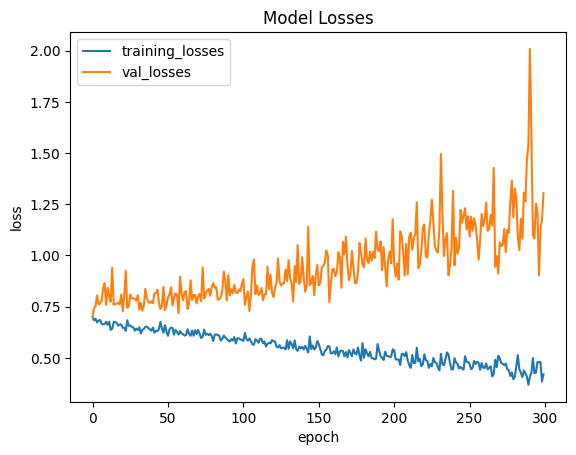

In [260]:
# Plot Generator and Discriminator Loss
plt.plot(training_losses, '-')
plt.plot(val_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(["training_losses", "val_losses"])
plt.title('Model Losses')

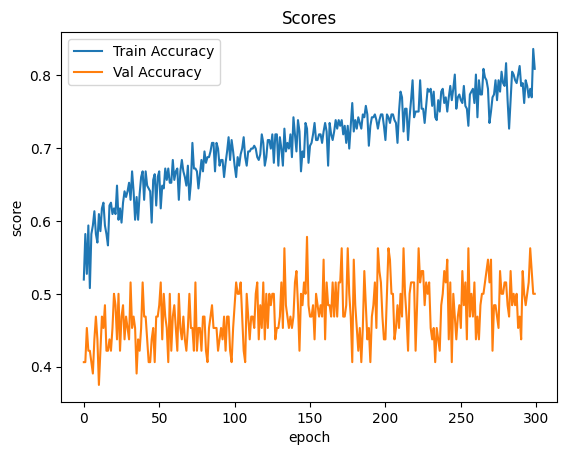

In [261]:
# Plot Real and Fake score
plt.plot(train_accuracy, '-')
plt.plot(val_accuracy, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Train Accuracy', "Val Accuracy"])
plt.title('Scores')
plt.show()

In [262]:
train_accuracy, training_losses, val_losses, val_accuracy = history2

Text(0.5, 1.0, 'Model Losses')

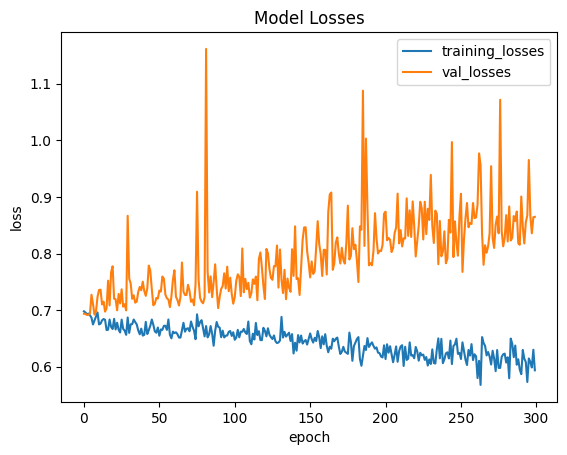

In [263]:
# Plot Generator and Discriminator Loss
plt.plot(training_losses, '-')
plt.plot(val_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(["training_losses", "val_losses"])
plt.title('Model Losses')

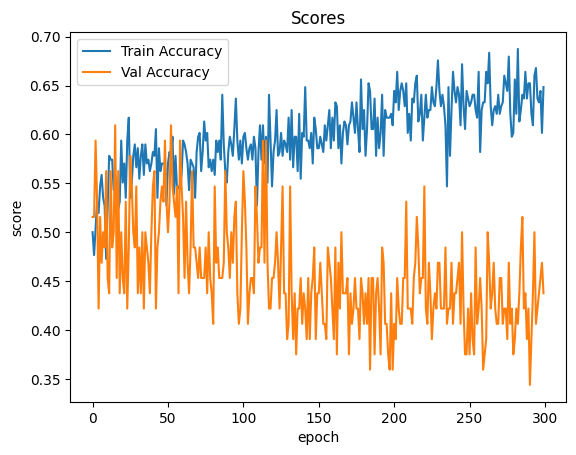

In [264]:
# Plot Real and Fake score
plt.plot(train_accuracy, '-')
plt.plot(val_accuracy, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Train Accuracy', "Val Accuracy"])
plt.title('Scores')
plt.show()

In [265]:
train_accuracy, training_losses, val_losses, val_accuracy = history3

Text(0.5, 1.0, 'Model Losses')

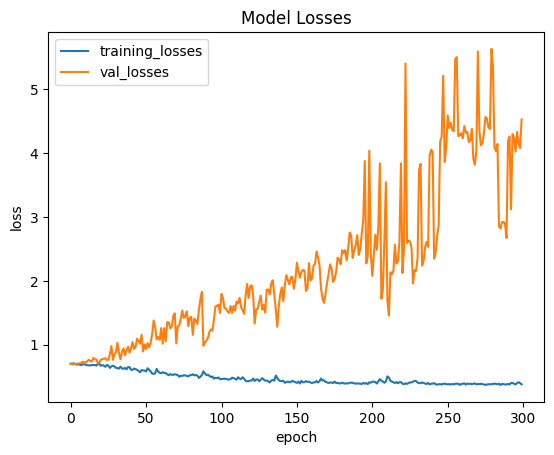

In [266]:
# Plot Generator and Discriminator Loss
plt.plot(training_losses, '-')
plt.plot(val_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(["training_losses", "val_losses"])
plt.title('Model Losses')

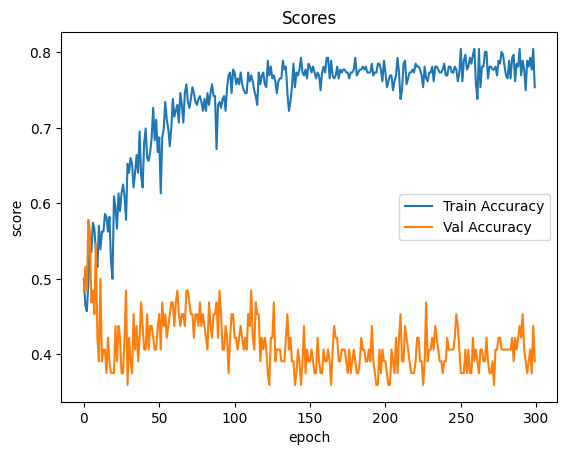

In [267]:
# Plot Real and Fake score
plt.plot(train_accuracy, '-')
plt.plot(val_accuracy, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Train Accuracy', "Val Accuracy"])
plt.title('Scores')
plt.show()